In [1]:
import glob
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from ipywidgets import interact, interactive
from preprocessing import VandalismEncoder, RevisionGrouper, FeatureSelector
from plotting import plot_confusion_matrix, plot_scores

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Load classifiers
classifiers = {}

def load_meta(base_dir, file_name):
    path = os.path.join(base_dir, file_name + '.meta')
    with open(path, 'r') as f:
        return json.load(f)

def load_clf(base_dir, file_name):
    path = os.path.join(base_dir, file_name + '.pkl')
    return joblib.load(path)

def clfs_are_same_version(clfs):
    hashes = [classifier['meta']['git_hash'] for tag_id, classifier in classifiers.items()]
    return len(set(hashes)) == 1

for f in os.listdir("./models/"):
    if f.endswith(".pkl"):
        filename = os.path.splitext(f)[0]
        print('Loading model', filename)
        meta = load_meta('./models/', filename)
        clf = load_clf('./models/', filename)
        tag_id = meta['tag_id']
        classifiers[tag_id] = {
            'clf': clf,
            'meta': meta
        }
        
# Version verification
assert clfs_are_same_version(classifiers), 'Warning loaded classifiers were not generated on the same git hash!'

Loading model tag_5
Loading model tag_6
Loading model tag_3
Loading model tag_2
Loading model tag_1
Loading model tag_11
Loading model tag_9


---
## Import Dataset

In [3]:
df = pd.read_csv('./data/features-total-2f8f6676.csv')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,revision_id,tag_id
0,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,34.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,228189784,12
1,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,0.833333,0.857143,0.5,...,0.0,1.0,0.0,0.134129,0.0,0.0,0.0,0.0,730449352,12
2,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,216224416,12
3,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,539338621,12
4,1.0,0.0,20.0,23.0,2.0,2.0,0.0,-1.000000,-1.000000,-1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,746191686,12


---
## Preprocessing

In [4]:
def preprocessing(features, tags):
    feature_columns = None
    selected_tags = []
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS
    
    if tags == 'all vandalism':
        selected_tags = [1, 2, 3, 5, 6, 9, 11]
    else:
        selected_tags.append(tags)

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder(selected_tags)),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    print('Feature config:', features, 'Selected tags:', selected_tags)
    return preprocess_pipeline.transform(df)
    
widget = interactive(preprocessing, features=['all', 'baseline'], tags=['all vandalism', 1, 2, 3, 5, 6, 9, 11, 12])
display(widget)

interactive(children=(Dropdown(description='features', options=('all', 'baseline'), value='all'), Dropdown(des…

In [5]:
processed_df = widget.result
print('Feature config:', widget.kwargs['features'], ', Features after preprocessing:', len(processed_df.columns))

Feature config: all , Features after preprocessing: 110


In [6]:
# X, y split
X = processed_df.drop(['is_vandalism'], axis=1)
y = processed_df['is_vandalism']

In [7]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (4452, 109)
y train (4452,)
X test (1484, 109)
y test (1484,)


In [8]:
estimators = [(str(tag_id), model['clf']) for tag_id, model in classifiers.items()]
clf = VotingClassifier(estimators, voting='soft', n_jobs=-1)

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


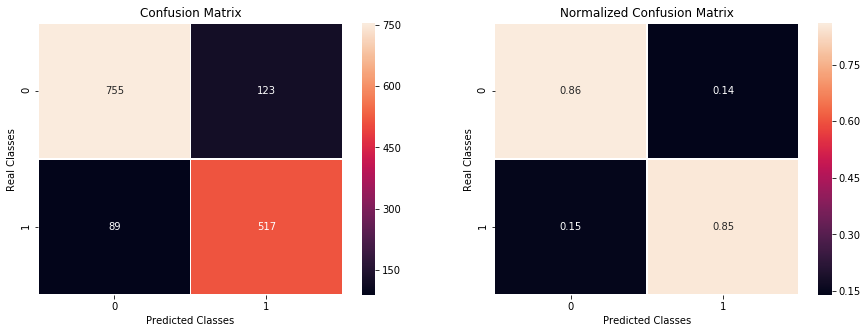

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.89      0.86      0.88       878
   Vandalism       0.81      0.85      0.83       606

 avg / total       0.86      0.86      0.86      1484



In [9]:
clf.fit(X_train, y_train)
y_test_predict = clf.predict(X_test)

plot_confusion_matrix(y_test, y_test_predict)